## Lec 4. 现代卷积神经网络

- 经典卷积神经网络 `LeNet` [1990.]
- 深度卷积神经网络 `AlexNet` [2012.] (ImageNet)
- 使用块的网络 `VGG` [2015. ]
- ......
- 残差网络 `ResNet`
- ......
- `Fast-RCNN`
- `YoLo系列`

### 4.1 AlexNet

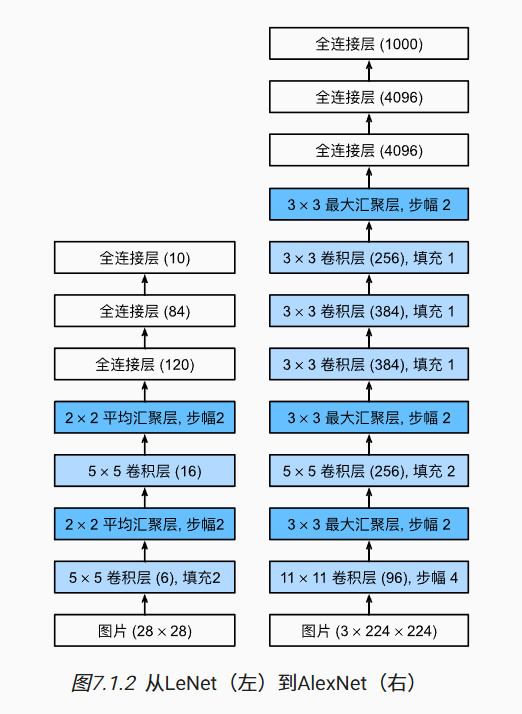

In [1]:
import torch
import torch.nn as nn

In [11]:
model = nn.Sequential(nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), 
                      nn.ReLU(), 
                      nn.MaxPool2d(kernel_size=3, stride=2), 
                      
                      nn.Conv2d(96, 256, kernel_size=5, padding=2), 
                      nn.ReLU(), 
                      nn.MaxPool2d(kernel_size=3, stride=2), 
                      
                      nn.Conv2d(256, 384, kernel_size=3, padding=1), 
                      nn.ReLU(), 
                      nn.Conv2d(384, 384, kernel_size=3, padding=1), 
                      nn.ReLU(), 
                      nn.Conv2d(384, 256, kernel_size=3, padding=1), 
                      nn.ReLU(), 
                      nn.MaxPool2d(kernel_size=3, stride=2), 
                      
                      nn.Flatten(), 
                      nn.Linear(256*5*5, 4096), 
                      nn.ReLU(), 
                      nn.Linear(4096, 4096), 
                      nn.ReLU(), 
                      nn.Linear(4096, 10))

model

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Linear(in_features=4096, out_features=4096, bias=True)
  (17): ReLU()
  (18): Linear(in_features=4096, out_features=10, bias=True)
)

In [15]:
import torchvision.transforms as transforms

# 定义变换
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
])

In [18]:
x = torch.rand(16, 1, 28, 28)  # [batch_size, channels, height, width]
x.shape

torch.Size([16, 1, 28, 28])

In [22]:
x = transform(x)
x.shape

torch.Size([16, 1, 224, 224])

In [23]:
model(x).shape

torch.Size([16, 10])

### 4.2 AlexNet 处理 Fasion-MNIST 图像识别任务

In [96]:
# 1. 构建数据集
import pandas as pd

df_dataset = pd.read_csv("./dataset/fashion-mnist_test.csv")  # 使用相对路径读取CSV文件, 得到DataFrame 数据帧

train_set = df_dataset.sample(frac=0.7)
test_set = df_dataset[~df_dataset.index.isin(train_set.index)]

train_set.shape, test_set.shape

((7000, 785), (3000, 785))

In [97]:
from torch.utils.data import Dataset, DataLoader

class FasionMNIST(Dataset):
    """ FasionMNIST图像识别数据集 """
    def __init__(self, df_dataset):
        self.y = df_dataset.label.values
        self.x = df_dataset.iloc[:, 1:].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        y = torch.LongTensor([self.y[idx]])
        x = torch.Tensor(self.x[idx])
        return y, x

train_dataset = FasionMNIST(train_set)
test_dataset = FasionMNIST(test_set)

len(train_dataset), len(test_dataset)

(7000, 3000)

In [98]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256)

len(train_dataloader), len(test_dataloader)

(28, 12)

In [99]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("mps")
device

device(type='cuda')

In [100]:
# 2. 构建模型
model = nn.Sequential(nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), 
                      nn.ReLU(), 
                      nn.MaxPool2d(kernel_size=3, stride=2), 
                      
                      nn.Conv2d(96, 256, kernel_size=5, padding=2), 
                      nn.ReLU(), 
                      nn.MaxPool2d(kernel_size=3, stride=2),
                      
                      nn.Conv2d(256, 384, kernel_size=3, padding=1), 
                      nn.ReLU(), 
                      nn.Conv2d(384, 384, kernel_size=3, padding=1), 
                      nn.ReLU(), 
                      nn.Conv2d(384, 256, kernel_size=3, padding=1), 
                      nn.ReLU(), 
                      nn.MaxPool2d(kernel_size=3, stride=2), 
                      
                      nn.Flatten(), 
                      nn.Dropout(0.5),  # 缓解过拟合
                      nn.Linear(256*5*5, 4096), 
                      nn.ReLU(), 
                      
                      nn.Dropout(0.3),  # 缓解过拟合
                      nn.Linear(4096, 4096), 
                      nn.ReLU(), 
                      nn.Linear(4096, 10))

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=6400, out_features=4096, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.3, inplace=False)
  (18): Linear(in_features=4096, out_features=4096, bias=True)
  (19): ReLU()
  (20): Linear(in_featu

In [101]:
# 3. 训练模型
def train_model(model, train_dataloader, optimizer, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.train() # 打开模型训练模式, 所有参数可以被调整
    for (y, x) in train_dataloader:
        # model input: [batch_size, channels, height, width]
        x = transform(x.view(x.shape[0], 1, 28, 28))
        y_hat = model(x.to(device))
        loss = loss_func(y_hat, y.to(device).view(y.shape[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(train_dataloader): 0.4f}")
    model.eval()
    return total_loss/len(train_dataloader)

# 4. 验证模型
def test_model(model, test_dataloader, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.eval() # 打开模型验证模式，所有参数冻结不可被调整
    for (y, x) in test_dataloader:
        x = transform(x.view(x.shape[0], 1, 28, 28))
        y_hat = model(x.to(device))
        loss = loss_func(y_hat, y.to(device).view(y.shape[0]))
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(test_dataloader): 0.4f}")
    model.train()
    return total_loss/len(test_dataloader)

In [102]:
epoch = 30

train_loss_records = []
test_loss_records = []

model = model.to(device)

for i in range(epoch):
    train_loss = train_model(model, train_dataloader, optimizer, loss_func)
    test_loss = test_model(model, test_dataloader, loss_func)
    
    train_loss_records.append(train_loss)
    test_loss_records.append(test_loss)

Total loss:  1.2132
Total loss:  0.7260
Total loss:  0.6020
Total loss:  0.5474
Total loss:  0.5064
Total loss:  0.4914
Total loss:  0.4520
Total loss:  0.4404
Total loss:  0.3997
Total loss:  0.4001
Total loss:  0.3668
Total loss:  0.3479
Total loss:  0.3361
Total loss:  0.3449
Total loss:  0.3031
Total loss:  0.3376
Total loss:  0.2865
Total loss:  0.3396
Total loss:  0.2836
Total loss:  0.3237
Total loss:  0.2556
Total loss:  0.3232
Total loss:  0.2390
Total loss:  0.3152
Total loss:  0.2314
Total loss:  0.3264
Total loss:  0.2190
Total loss:  0.3103
Total loss:  0.2083
Total loss:  0.3248
Total loss:  0.1825
Total loss:  0.3240
Total loss:  0.1845
Total loss:  0.3198
Total loss:  0.1698
Total loss:  0.3133
Total loss:  0.1649
Total loss:  0.3517
Total loss:  0.1549
Total loss:  0.3074
Total loss:  0.1251
Total loss:  0.3193
Total loss:  0.1276
Total loss:  0.3444
Total loss:  0.1258
Total loss:  0.3425
Total loss:  0.1132
Total loss:  0.3511
Total loss:  0.1074
Total loss:  0.3344


KeyboardInterrupt: 

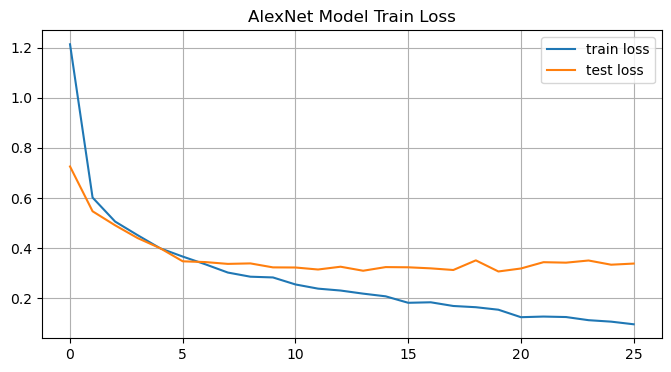

In [103]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss_records, label="train loss")
plt.plot(test_loss_records, label="test loss")
plt.title("AlexNet Model Train Loss")
plt.legend()

plt.grid()
plt.show()

### 4.3 Dropout

In [93]:
model = nn.Dropout(0.5)
model

Dropout(p=0.5, inplace=False)

In [94]:
x = torch.rand(2, 4)
x

tensor([[0.5242, 0.6608, 0.6744, 0.2893],
        [0.6340, 0.6222, 0.5161, 0.7920]])

In [95]:
model(x)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [1.2680, 0.0000, 1.0321, 0.0000]])

### 4.4 模型的保存和载入

In [106]:
model

Sequential(
  (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=6400, out_features=4096, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.3, inplace=False)
  (18): Linear(in_features=4096, out_features=4096, bias=True)
  (19): ReLU()
  (20): Linear(in_featu

In [105]:
# 返回model的所有paramters
model.state_dict()

OrderedDict([('0.weight',
              tensor([[[[ 0.0462, -0.0082, -0.0330,  ..., -0.0742,  0.0722, -0.0108],
                        [ 0.0197, -0.0777,  0.0368,  ..., -0.0584, -0.0777,  0.0514],
                        [ 0.0712, -0.0333, -0.0229,  ...,  0.0825, -0.0653,  0.0806],
                        ...,
                        [ 0.0727,  0.0118,  0.0631,  ..., -0.0421, -0.0199, -0.0167],
                        [ 0.0267, -0.0555,  0.0317,  ...,  0.0859,  0.0242,  0.0965],
                        [ 0.0876,  0.0738,  0.0166,  ...,  0.0786, -0.0084, -0.0126]]],
              
              
                      [[[ 0.0260,  0.0036,  0.0815,  ...,  0.0560, -0.0111,  0.0268],
                        [-0.0485,  0.0411,  0.0455,  ...,  0.0848, -0.0793,  0.0020],
                        [-0.0634, -0.0869, -0.0734,  ...,  0.0495,  0.0207,  0.0525],
                        ...,
                        [ 0.0307, -0.0465, -0.0067,  ..., -0.0655, -0.0540, -0.0746],
                        

In [107]:
# 把模型的参数 parameters 保存为本地文件
torch.save(model.state_dict(), "AlexNet.pt")

In [110]:
import warnings
warnings.filterwarnings("ignore")

# 读取本地模型参数到新建立的model对象中
# model = ....... 
model.load_state_dict(torch.load("AlexNet.pt"))

<All keys matched successfully>

### 4.5 VGG 使用块的网络 - 视觉几何组（visual geometry group）

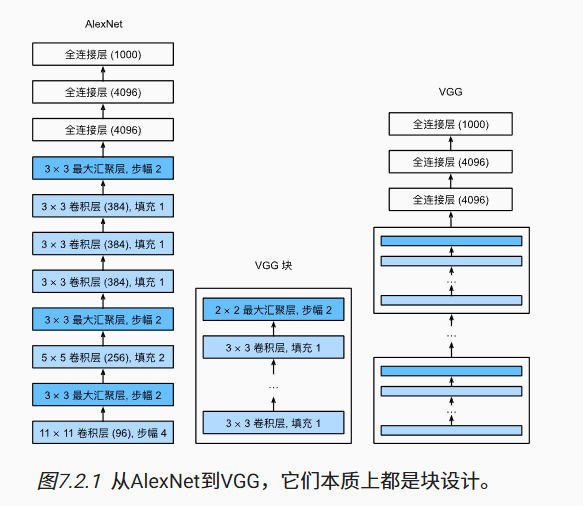

In [113]:
def vgg_block(num_conv: int, in_channels: int, out_channels: int) -> nn.Module:
    """ VGG块构建函数 """
    layers = []
    for i in range(num_conv):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())

        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [120]:
def vgg(conv_arch: list) -> nn.Module:
    """ VGG网络构建函数 """
    conv_block = []
    in_channels = 1
    # 卷积网络部分 Feature Extract
    for (num_conv, out_channels) in conv_arch:
        vgg_block_layer = vgg_block(num_conv, in_channels, out_channels)
        conv_block.append(vgg_block_layer)
        in_channels = out_channels
    
    # 全连接网络部分 Classifier
    model = nn.Sequential(*conv_block,  # [vgg1, vgg2, vgg3, vg4, vgg5]
                          nn.Flatten(), 
                          nn.Linear(out_channels*7*7, 4096), 
                          nn.ReLU(), 
                          
                          nn.Linear(4096, 4096), 
                          nn.ReLU(), 
                          
                          nn.Linear(4096, 10))
    return model

In [124]:
conv_arch = [(1, 64), (1, 128), (2, 256), (2, 512), (2, 512)]  # (16, 1, 224, 224) -> 减半5次得到 7x7特征图
model = vgg(conv_arch)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
 

In [125]:
x = torch.rand(16, 1, 224, 224)
model(x).shape

torch.Size([16, 10])

### 4.6 VGG 处理 Fasion-MNIST 图像识别任务

In [126]:
# 1. 构建数据集
import pandas as pd

df_dataset = pd.read_csv("./dataset/fashion-mnist_test.csv")  # 使用相对路径读取CSV文件, 得到DataFrame 数据帧

train_set = df_dataset.sample(frac=0.7)
test_set = df_dataset[~df_dataset.index.isin(train_set.index)]

print(train_set.shape, test_set.shape)

from torch.utils.data import Dataset, DataLoader

class FasionMNIST(Dataset):
    """ FasionMNIST图像识别数据集 """
    def __init__(self, df_dataset):
        self.y = df_dataset.label.values
        self.x = df_dataset.iloc[:, 1:].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        y = torch.LongTensor([self.y[idx]])
        x = torch.Tensor(self.x[idx])
        return y, x

train_dataset = FasionMNIST(train_set)
test_dataset = FasionMNIST(test_set)

len(train_dataset), len(test_dataset)

(7000, 785) (3000, 785)


(7000, 3000)

In [135]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128)

len(train_dataloader), len(test_dataloader)

(55, 24)

In [136]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("mps")
device

device(type='cuda')

In [137]:
# 2. 构建模型
conv_arch = [(1, 64), (1, 128), (2, 256), (2, 512), (2, 512)]  # (16, 1, 224, 224) -> 减半5次得到 7x7特征图
model = vgg(conv_arch)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [139]:
# 3. 训练模型
def train_model(model, train_dataloader, optimizer, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.train() # 打开模型训练模式, 所有参数可以被调整
    for (y, x) in train_dataloader:
        # model input: [batch_size, channels, height, width]
        x = transform(x.view(x.shape[0], 1, 28, 28))
        y_hat = model(x.to(device))
        loss = loss_func(y_hat, y.to(device).view(y.shape[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(train_dataloader): 0.4f}")
    model.eval()
    return total_loss/len(train_dataloader)

# 4. 验证模型
def test_model(model, test_dataloader, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.eval() # 打开模型验证模式，所有参数冻结不可被调整
    for (y, x) in test_dataloader:
        x = transform(x.view(x.shape[0], 1, 28, 28))
        y_hat = model(x.to(device))
        loss = loss_func(y_hat, y.to(device).view(y.shape[0]))
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(test_dataloader): 0.4f}")
    model.train()
    return total_loss/len(test_dataloader)

In [140]:
epoch = 30

train_loss_records = []
test_loss_records = []

model = model.to(device)

for i in range(epoch):
    train_loss = train_model(model, train_dataloader, optimizer, loss_func)
    test_loss = test_model(model, test_dataloader, loss_func)
    
    train_loss_records.append(train_loss)
    test_loss_records.append(test_loss)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss_records, label="train loss")
plt.plot(test_loss_records, label="test loss")
plt.title("AlexNet Model Train Loss")
plt.legend()

plt.grid()
plt.show()

### 4.7 ResNet 残差网络

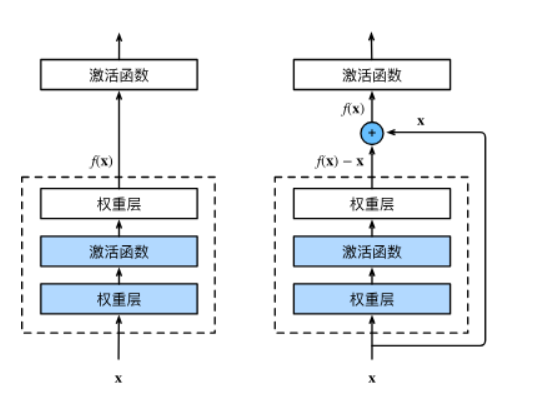

In [155]:
model = nn.Linear(784, 784)

x = torch.rand(16, 1, 784)
x.shape

torch.Size([16, 1, 784])

In [156]:
output = model(x)  # 普通结构
output.shape

torch.Size([16, 1, 784])

In [157]:
output = model(x) + x  # 残差结构
output.shape

torch.Size([16, 1, 784])